In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chess
import chess.svg
import chess.engine
import json
import time
from pathlib import Path
from enum import Enum
from IPython.display import display, SVG

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 512
RESULTS_DIR = Path("experiments/results")
LOGS_DIR = Path("experiments/logs")
MODEL_DIR = Path("models")

# ==========================================
MODEL_NAME = "transformer_test_run"
MODEL_TYPE = "Transformer"
MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}.pth"
FAILURE_INDICES_PATH = RESULTS_DIR / MODEL_NAME /"transformer_test_run_failure_indices.json"   
# ==========================================

TEST_PATH = Path("./dataset_planes_cp/plane_test.npz") 


In [18]:
import math
import torch
import torch.nn as nn

class Ffn(nn.Module):
    """
    Corresponds to 'shared.py'.
    """
    def __init__(self, embed_dim, ffn_dim):
        super().__init__()
        self.linear1 = nn.Linear(embed_dim, ffn_dim)
        self.activation = nn.ReLU() 
        self.linear2 = nn.Linear(ffn_dim, embed_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

class EncoderBlock(nn.Module):
    """
    Corresponds to 'encoder.py'.
    """
    def __init__(self, embed_dim, num_heads, ffn_dim, num_blocks):
        super().__init__()
        # DeepNorm: to prevent exploding variance, Post-Norm is actually capable of higher accuracy than Pre-Norm, if you can stop it from exploding during training.
        self.alpha = math.pow(2.0 * num_blocks, -0.25)
        
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ffn = Ffn(embed_dim, ffn_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_out, _ = self.mha(x, x, x)
        x = x + attn_out * self.alpha
        identity = self.ln1(x)
        ffn_out = self.ffn(identity)
        x = identity + ffn_out * self.alpha # residual sum
        x = self.ln2(x)
        return x

class Transformer(nn.Module):
    def __init__(self, input_channels=19, embed_dim=256, num_heads=8, ffn_dim=1024, num_blocks=10, num_classes=7):
        super().__init__()
    
        # Leela first compress the all global pieces into a vector, embed it and append it to each square again
        # This way, all squares know where all other pieces are; But can consider that as a TODO
        
        # Linear only looks at the last dimension in input tensor
        self.embedding = nn.Linear(input_channels, embed_dim)

        self.embed_activation = nn.ReLU()
        self.embed_norm = nn.LayerNorm(embed_dim)

        # We learn 64 unique vectors. We let the model figure out where they are relative to each other.
        self.pos_embedding = nn.Parameter(torch.randn(1, 64, embed_dim))
        nn.init.normal_(self.pos_embedding, mean=0, std=0.02)
        
        # Transformer Tower
        self.blocks = nn.ModuleList([EncoderBlock(embed_dim, num_heads, ffn_dim, num_blocks) for _ in range(num_blocks)])
        
        self.classifier_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Linear(embed_dim // 2, num_classes)
        )
        

    def forward(self, x):
        # Reshape (Batch, 19, 8, 8) to (Batch, 64, 19)
        x = x.permute(0, 2, 3, 1).flatten(1, 2)
    
        x = self.embedding(x) # Input: (Batch, 64, 19); Output: (Batch, 64, embed_dim)
        x = self.embed_activation(x)
        x = self.embed_norm(x)
        
        x = x + self.pos_embedding # (1, 64, embed_dim) is broadcasted to (Batch, 64, embed_dim)
 
        for block in self.blocks:
            x = block(x)
        
        # Global Pooling, Average all 64 squares to get one vector for the board
        x = x.mean(dim=1) # Input: (Batch, 64, embed_dim); Output: (Batch, embed_dim)
        
        logits = self.classifier_head(x) # Shape: (Batch, 7)
        
        return logits

In [19]:
ROOT_DIR = Path("./dataset_planes_cp/")

class ChessDataset(Dataset):
    def __init__(self, root_dir: Path, split: str):
        self.root_dir = Path(root_dir)
        self.split = split
        self.X = np.load(self.root_dir / f"{self.split}_X.npy", mmap_mode='r')
        self.y = np.load(self.root_dir / f"{self.split}_y.npy", mmap_mode='r')

    def __len__(self) -> int:
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X, y 

def get_test_loader():
    dataset = ChessDataset(root_dir=ROOT_DIR, split="test")
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [20]:
hyperparams = {
    "input_channels": 19,
    "embed_dim": 128,   
    "num_heads": 4,    
    "ffn_dim": 512,     
    "num_blocks": 6,    
    "num_classes": 7   
}

model = Transformer(**hyperparams).to(DEVICE)

try:
    model.load_state_dict(torch.load(MODEL_PATH))
    print(f"Loaded weights from {MODEL_PATH}")
except FileNotFoundError:
    print("Weight file not found! Please check MODEL_PATH.")

model.eval()
print("Model ready.")

Loaded weights from models\transformer_test_run.pth
Model ready.


In [21]:
import sys, asyncio

if sys.platform.startswith("win"):
    stockfish_executable_path = Path("./stockfish/stockfish-windows-x86-64-avx2.exe")
    print(f"Using Stockfish executable: {stockfish_executable_path}")

if sys.platform.startswith("darwin"):
    stockfish_executable_path = Path("./stockfish/stockfish-macos-m1-apple-silicon")
    print(f"Using Stockfish executable: {stockfish_executable_path}")

if sys.platform.startswith("win"):
    print(f"Initial Policy: {type(asyncio.get_event_loop_policy()).__name__}")
    asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())
    print(f"New Policy: {type(asyncio.get_event_loop_policy()).__name__}")
        
def get_score_label(fen: str, depth: int = 10) -> float:      
    engine = None
    engine = chess.engine.SimpleEngine.popen_uci(str(stockfish_executable_path))
    
    board = chess.Board(fen)

    info = engine.analyse(board, chess.engine.Limit(depth=depth))
    cp = info["score"].white().score(mate_score=10000)

    if engine:
        engine.quit()
            
    if cp >= 500:       return 0
    if 500 > cp >= 300: return 1
    if 300 > cp >= 100: return 2
    if 100 > cp > -100: return 3
    if -100 >= cp > -300: return 4
    if -300 > cp >= -500: return 5
    return 6 

Using Stockfish executable: stockfish\stockfish-windows-x86-64-avx2.exe
Initial Policy: WindowsProactorEventLoopPolicy
New Policy: WindowsProactorEventLoopPolicy


In [22]:
def get_piece_gradients(model, input_tensor, target_class):
    """
    Computes the gradient of the score for the target class w.r.t the input vector.
    """
    model.eval()
    input_tensor.requires_grad = True

    pred = model(input_tensor)
    score = pred[0, target_class]

    score.backward()
    
    gradients = input_tensor.grad.data.cpu().numpy()[0]
    
    return gradients

def plot_chess_gradients(gradients):
    """
    Visualizes the gradient vector with clear labeling for chess piece blocks.
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax1.plot(gradients, color="b", linewidth=1, label='Gradient Magnitude')
    channels = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']
    block_size = 64
    
    # Dynamic Y-limit to place text just above the data
    y_min, y_max = np.min(gradients), np.max(gradients)
    y_range = y_max - y_min
    text_y_pos = y_max + (y_range * 0.05) 
    
    # Add Shading and Labels for each Piece Block
    for i, channel in enumerate(channels):
        start_idx = i * block_size
        end_idx = (i + 1) * block_size
        if i % 2 == 0:
            ax1.axvspan(start_idx, end_idx, color='gray', alpha=0.1, lw=0)
        ax1.axvline(x=end_idx, color='gray', linestyle=':', alpha=0.5)
        ax1.text(start_idx + block_size/2, text_y_pos, channel, 
                 ha='center', va='bottom', fontsize=12, fontweight='bold', color='#333333')

    ax1.set_title('Gradient Sensitivity by Feature Index', fontsize=14, pad=25)
    ax1.set_xlabel('Feature Index')
    ax1.set_ylabel('Gradient Value')
    ax1.set_xlim(0, 767)
    ax1.set_ylim(y_min, y_max + (y_range * 0.15))
    ax1.grid(True, axis='y', alpha=0.3, linestyle='--')
    sns.despine()
    plt.tight_layout()
    plt.show()

def plot_chess_heatmap(gradients, fen_str, true_label, pred_label):
    """
    Aggregates gradients from the 12 bitboards (first 768 indices) into a 8x8 grid.
    """
    # Reshape first 768 features into (12 channels, 64 squares)
    # The order of channels : P, N, B, R, Q, K, p, n, b, r, q, k
    piece_grads = gradients[:768].reshape(12, 64)
    
    # Sum absolute gradients across all piece channels to get importance per square
    # Shape becomes (64,)
    saliency = np.sum(np.abs(piece_grads), axis=0)
    
    # Reshape into 8x8 board
    heatmap = saliency.reshape(8, 8)
    
    # Matplotlib plots 0 at top-left by default, but chess Index 0 is a1 (bottom-left).
    # We need to flip vertically for imshow to put Rank 8 at top.
    heatmap = np.flipud(heatmap) 

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(heatmap, cmap="viridis", alpha=0.7, zorder=2, ax=ax, cbar=False)
    ax.set_title(f"Saliency Map (True: {true_label}, Pred: {pred_label})")
    plt.show()
    print("Actual Board Position:")
    display(chess.svg.board(chess.Board(fen_str), size=350))

def tensor_to_fen(tensor):
    """
    Reconstructs a FEN string from the (19, 8, 8) tensor.
    """
    index_to_piece = {
        0: 'P', 1: 'N', 2: 'B', 3: 'R', 4: 'Q', 5: 'K',
        6: 'p', 7: 'n', 8: 'b', 9: 'r', 10: 'q', 11: 'k'
    }

    board = chess.Board(None)

    for piece_idx in range(12):
        for row in range(8):
            for col in range(8):
                if tensor[piece_idx, row, col] == 1:
                    piece = chess.Piece.from_symbol(index_to_piece[piece_idx])
                    # square calculation: row * 8 + col
                    board.set_piece_at(chess.square(col, row), piece)

    board.turn = chess.WHITE if tensor[12, 0, 0] == 1 else chess.BLACK

    castling_fen = ""
    if tensor[13, 0, 0] == 1: castling_fen += "K"
    if tensor[14, 0, 0] == 1: castling_fen += "Q"
    if tensor[15, 0, 0] == 1: castling_fen += "k"
    if tensor[16, 0, 0] == 1: castling_fen += "q"
    if castling_fen == "": castling_fen = "-"
    
    board.set_castling_fen(castling_fen)

    ep_rows, ep_cols = np.where(tensor[18] == 1)
    if len(ep_rows) > 0:
        board.ep_square = chess.square(ep_cols[0], ep_rows[0])

    return board.fen()

FEN: 8/p4pkp/1pr1q1p1/n3p3/6P1/4Q2P/PB6/3R1BK1 b - - 4 34
True Label: 2 | Predicted: 1
Error Magnitude: 1


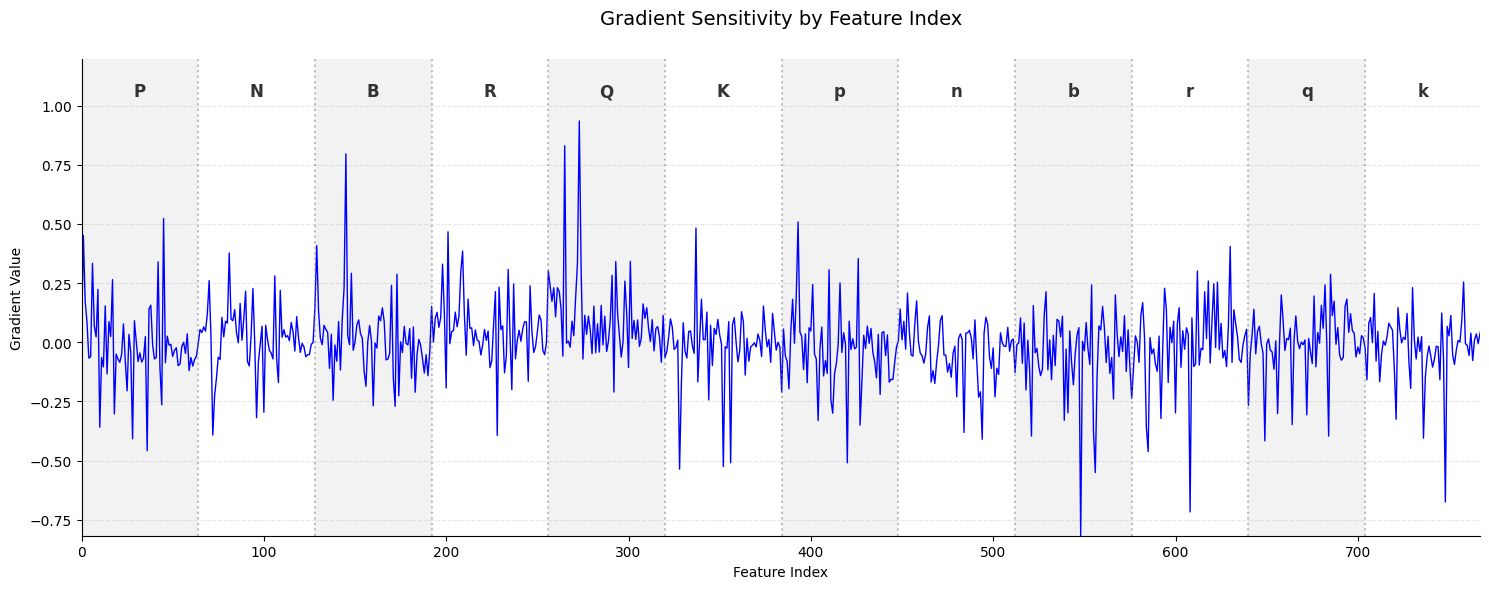

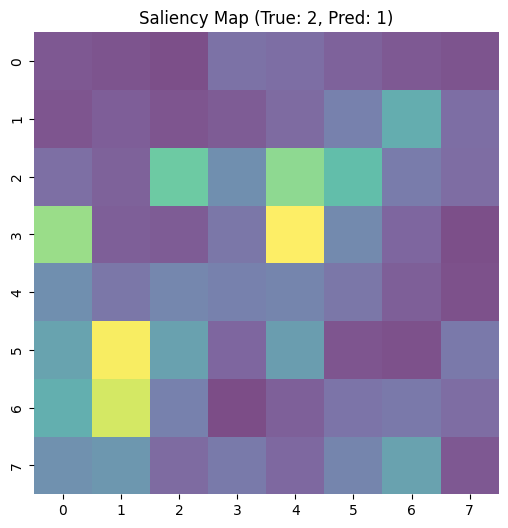

Actual Board Position:


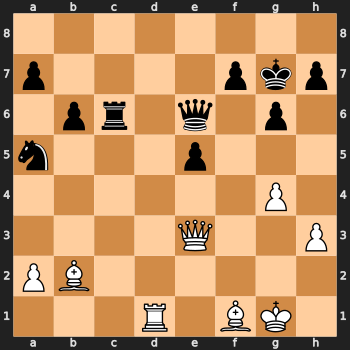

In [27]:
def fen_to_tensor(fen):
    """
    Converts FEN into a (19, 8, 8) tensor.
    """
    board = chess.Board(fen)
    tensor = np.zeros((19, 8, 8), dtype=np.uint8)

    piece_to_channel = {
        "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
        "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
    }

    for square, piece in board.piece_map().items():
        channel = piece_to_channel[piece.symbol()]
        row, col = divmod(square, 8)
        tensor[channel, row, col] = 1

    
    if board.turn == chess.WHITE:
        tensor[12, :, :] = 1
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[13, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[14, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[15, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[16, :, :] = 1
    if board.is_check():
        tensor[17, :, :] = 1

    if board.ep_square is not None:
        row, col = divmod(board.ep_square, 8)
        tensor[18, row, col] = 1

    return tensor

fen = "8/p4pkp/1pr1q1p1/n3p3/6P1/4Q2P/PB6/3R1BK1 b - - 4 34"

numpy_fen = fen_to_tensor(fen) 
X_input = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(DEVICE)

# Predict
model.eval()
pred_logits = model(X_input)
pred_label = torch.argmax(pred_logits, dim=1).item()

# Generate Saliency to see why it predicted the wrong class
grads = get_piece_gradients(model, X_input, pred_label)

if len(grads.shape) == 3:  # Check if shape is (19, 8, 8)
    grads = grads.flatten()

true_label = get_score_label(fen)

print(f"FEN: {fen}")
print(f"True Label: {true_label} | Predicted: {pred_label}")
print(f"Error Magnitude: {abs(true_label - pred_label)}")

plot_chess_gradients(grads)
plot_chess_heatmap(grads, fen_str=fen, true_label=true_label, pred_label=pred_label)

In [9]:
with open(FAILURE_INDICES_PATH, "r") as f:
    failure_data = json.load(f)

# ==========================================
ERROR_MAGNITUDE = "3"  # Choose from '3', '4', '5', '6' 
FAILURE_IDX_IN_LIST = 1 # Pick the Nth failure in that category
# ==========================================

dataset_idx = failure_data[ERROR_MAGNITUDE][FAILURE_IDX_IN_LIST]

# Load that specific sample
dataset = ChessDataset(root_dir=ROOT_DIR, split="test")
X_sample, y_sample = dataset[dataset_idx]
print(X_sample, y_sample)    
# # Unsqueeze so [775] > [1, 775] as model expects batch
# X_input = X_sample.unsqueeze(0).to(DEVICE)

# # Predict
# model.eval()
# pred_logits = model(X_input)
# pred_label = torch.argmax(pred_logits, dim=1).item()

# # Generate Saliency to see why it predicted the wrong class
# grads = get_piece_gradients(model, X_input, pred_label)

# if len(grads.shape) == 3:  # Check if shape is (19, 8, 8)
#     grads = grads.flatten()

# # Reconstruct FEN for visualization
# reconstructed_fen = tensor_to_fen(X_sample)

# print(f"Analyzing Test Sample Index: {dataset_idx}")
# print(f"FEN: {reconstructed_fen}")
# print(f"True Label: {y_sample.item()} | Predicted: {pred_label}")
# print(f"Error Magnitude: {abs(y_sample.item() - pred_label)}")

# plot_chess_gradients(grads)
# plot_chess_heatmap(grads, fen_str=reconstructed_fen, true_label=y_sample.item(), pred_label=pred_label)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

Saved new log to experiments\results\transformer_test_run\accuracy_vs_piece_count.csv


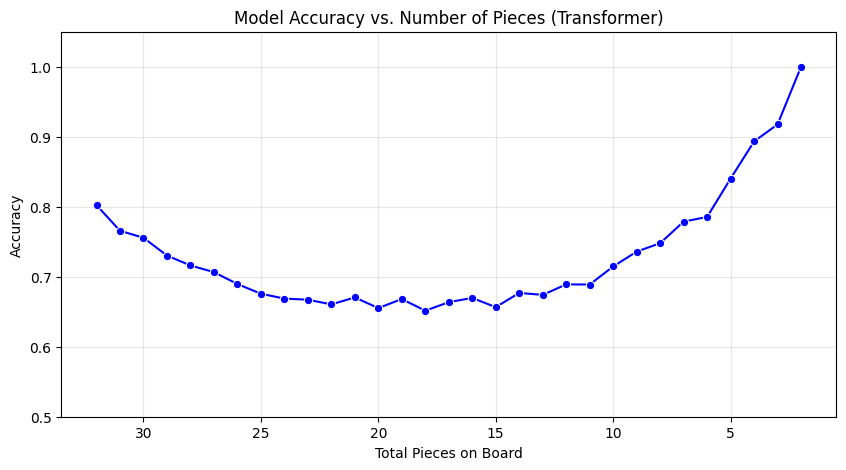

In [28]:
PIECE_ACC_LOG = RESULTS_DIR / MODEL_NAME / "accuracy_vs_piece_count.csv"

def compute_piece_accuracy(model, dataloader):
    results = []
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds = model(X).argmax(dim=1)
            
            piece_counts = X[:, :768].sum(dim=1).cpu().numpy()
            correct = (preds == y).cpu().numpy()
            
            for count, is_correct in zip(piece_counts, correct):
                results.append({"piece_count": int(count), "correct": int(is_correct)})
                
    df = pd.DataFrame(results)
    # Group by piece count and calc mean accuracy
    summary = df.groupby("piece_count")["correct"].mean().reset_index()
    summary.rename(columns={"correct": "accuracy"}, inplace=True)
    return summary

def compute_piece_accuracy_resnet(model, dataloader):
    results = []
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds = model(X).argmax(dim=1)
            
            piece_counts = X[:, :12, :, :].sum(dim=(1, 2, 3)).cpu().numpy()
            
            correct = (preds == y).cpu().numpy()
            
            for count, is_correct in zip(piece_counts, correct):
                results.append({"piece_count": int(count), "correct": int(is_correct)})
                
    df = pd.DataFrame(results)
    # Group by piece count and calc mean accuracy
    summary = df.groupby("piece_count")["correct"].mean().reset_index()
    summary.rename(columns={"correct": "accuracy"}, inplace=True)
    return summary

# Check if exists
if PIECE_ACC_LOG.exists():
    print(f"Loading existing log from {PIECE_ACC_LOG}...")
    df_piece_acc = pd.read_csv(PIECE_ACC_LOG)
else:
    test_loader = get_test_loader()
    df_piece_acc = compute_piece_accuracy_resnet(model, test_loader)
    df_piece_acc.to_csv(PIECE_ACC_LOG, index=False)
    print(f"Saved new log to {PIECE_ACC_LOG}")


plt.figure(figsize=(10, 5))
sns.lineplot(data=df_piece_acc, x="piece_count", y="accuracy", marker="o", color="blue")
plt.title(f"Model Accuracy vs. Number of Pieces ({MODEL_TYPE})")
plt.xlabel("Total Pieces on Board")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.05)
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

Saved new log to experiments\results\transformer_test_run\accuracy_vs_phase.csv


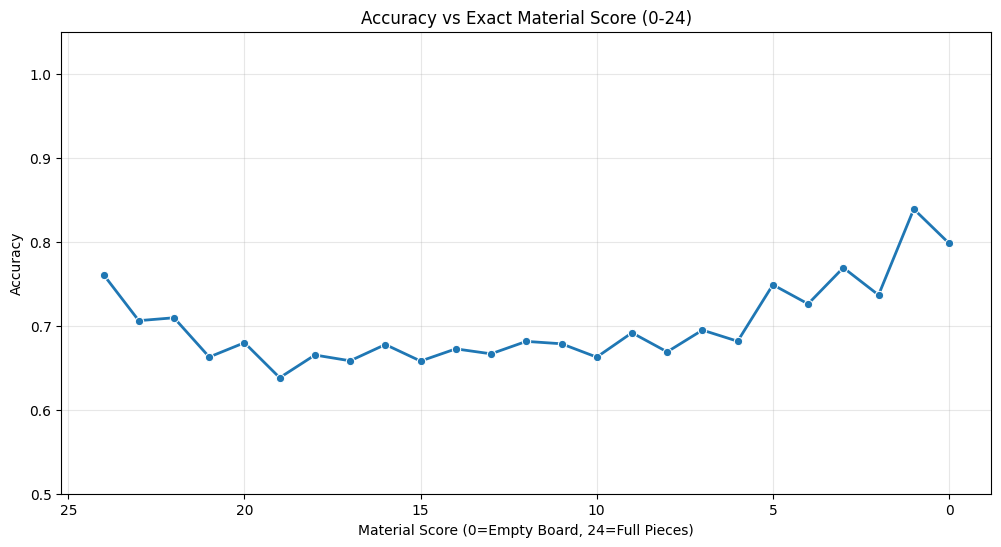

In [29]:
PHASE_ACC_LOG = RESULTS_DIR / MODEL_NAME / "accuracy_vs_phase.csv"

def compute_phase_accuracy(model, dataloader):
    results = []
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds = model(X).argmax(dim=1)

            X_cpu = X.cpu().numpy()
            correct_batch = (preds == y).cpu().numpy() 
            
            n_count = np.sum(X_cpu[:, 64:128], axis=1) + np.sum(X_cpu[:, 448:512], axis=1)
            b_count = np.sum(X_cpu[:, 128:192], axis=1) + np.sum(X_cpu[:, 512:576], axis=1)
            r_count = np.sum(X_cpu[:, 192:256], axis=1) + np.sum(X_cpu[:, 576:640], axis=1)
            q_count = np.sum(X_cpu[:, 256:320], axis=1) + np.sum(X_cpu[:, 640:704], axis=1)
            
            # Formula: N*1 + B*1 + R*2 + Q*4
            phases = (n_count * 1) + (b_count * 1) + (r_count * 2) + (q_count * 4)
            phases = np.minimum(phases, 24).astype(int)

            for phase_score, is_corr in zip(phases, correct_batch):
                results.append({
                    "material_score": phase_score, 
                    "correct": int(is_corr)
                })

    df = pd.DataFrame(results)
    summary = df.groupby("material_score", observed=False)["correct"].mean().reset_index()    
    return summary

def compute_phase_accuracy_resnet(model, dataloader):
    results = []
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds = model(X).argmax(dim=1)

            n_count = X[:, 1, :, :].sum(dim=(1, 2)).cpu().numpy() + \
                      X[:, 7, :, :].sum(dim=(1, 2)).cpu().numpy()
            b_count = X[:, 2, :, :].sum(dim=(1, 2)).cpu().numpy() + \
                      X[:, 8, :, :].sum(dim=(1, 2)).cpu().numpy()
            r_count = X[:, 3, :, :].sum(dim=(1, 2)).cpu().numpy() + \
                      X[:, 9, :, :].sum(dim=(1, 2)).cpu().numpy()
            q_count = X[:, 4, :, :].sum(dim=(1, 2)).cpu().numpy() + \
                      X[:, 10, :, :].sum(dim=(1, 2)).cpu().numpy()

            correct_batch = (preds == y).cpu().numpy()
            
            # Formula: N*1 + B*1 + R*2 + Q*4
            phases = (n_count * 1) + (b_count * 1) + (r_count * 2) + (q_count * 4)
            phases = np.minimum(phases, 24).astype(int)

            for phase_score, is_corr in zip(phases, correct_batch):
                results.append({
                    "material_score": phase_score, 
                    "correct": int(is_corr)
                })

    df = pd.DataFrame(results)
    summary = df.groupby("material_score", observed=False)["correct"].mean().reset_index()    
    return summary

if PHASE_ACC_LOG.exists():
    print(f"Loading existing log from {PHASE_ACC_LOG}...")
    df_phase = pd.read_csv(PHASE_ACC_LOG)
else:
    test_loader = get_test_loader()
    df_phase = compute_phase_accuracy_resnet(model, test_loader)
    df_phase.to_csv(PHASE_ACC_LOG, index=False)
    print(f"Saved new log to {PHASE_ACC_LOG}")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_phase, x="material_score", y="correct", marker="o", linewidth=2)
plt.title("Accuracy vs Exact Material Score (0-24)")
plt.xlabel("Material Score (0=Empty Board, 24=Full Pieces)")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.05)
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

Scanning for 'Positional Wins' (Equal Material, but Decisive Result)...
Saved new positional report to experiments\results\transformer_test_run\positional_report.json
----------------------------------------
POSITIONAL UNDERSTANDING REPORT
----------------------------------------
Total Positions Analyzed: 200455
Model Accuracy:           69.49%
----------------------------------------
Breakdown of Errors:
  Mistook for Draw:       17961
  Picked Wrong Winner:    43188
----------------------------------------


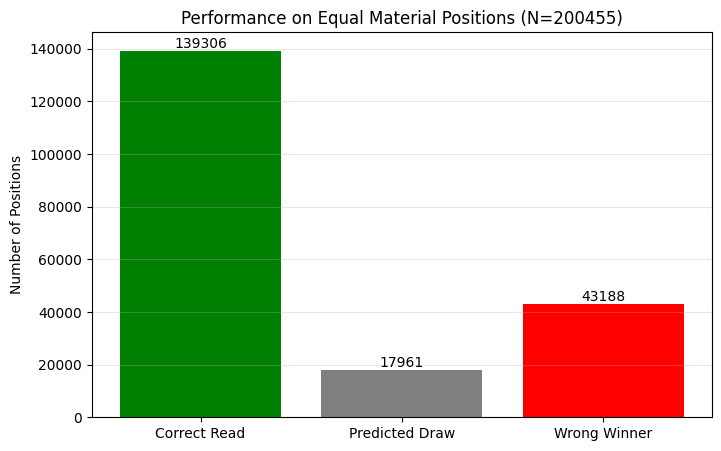

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

POSITIONAL_LOG = RESULTS_DIR / MODEL_NAME / "positional_report.json"

def generate_positional_report_resnet(model, dataloader, device):
    print("Scanning for 'Positional Wins' (Equal Material, but Decisive Result)...")
    model.eval()
    
    total_material_equal_positions = 0
    correct_positional_reads = 0
    predicted_draw_count = 0        # Model predicted Draw (Class 3)
    predicted_wrong_winner_count = 0 # Model predicted wrong winner but not Draw

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            
            w_score = (X[:, 0, :, :].sum(dim=(1, 2)) * 1) + \
                      (X[:, 1, :, :].sum(dim=(1, 2)) * 3) + \
                      (X[:, 2, :, :].sum(dim=(1, 2)) * 3) + \
                      (X[:, 3, :, :].sum(dim=(1, 2)) * 5) + \
                      (X[:, 4, :, :].sum(dim=(1, 2)) * 9)

            b_score = (X[:, 6, :, :].sum(dim=(1, 2)) * 1) + \
                      (X[:, 7, :, :].sum(dim=(1, 2)) * 3) + \
                      (X[:, 8, :, :].sum(dim=(1, 2)) * 3) + \
                      (X[:, 9, :, :].sum(dim=(1, 2)) * 5) + \
                      (X[:, 10, :, :].sum(dim=(1, 2)) * 9)

            w_score_np = w_score.cpu().numpy()
            b_score_np = b_score.cpu().numpy()
            y_cpu = y.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            is_equal_material = (w_score_np == b_score_np)

            is_decisive = (y_cpu != 3)
            
            target_indices = np.where(is_equal_material & is_decisive)[0]
            
            if len(target_indices) > 0:
                total_material_equal_positions += len(target_indices)
                
                relevant_preds = preds_cpu[target_indices]
                relevant_labels = y_cpu[target_indices]
                
                matches = (relevant_preds == relevant_labels)
                correct_positional_reads += np.sum(matches)
                
                errors = ~matches
                error_preds = relevant_preds[errors]
                
                predicted_draw_count += np.sum(error_preds == 3)
                predicted_wrong_winner_count += np.sum(error_preds != 3)

    accuracy = 0
    if total_material_equal_positions > 0:
        accuracy = correct_positional_reads / total_material_equal_positions

    report = {
        "total_positions": int(total_material_equal_positions),
        "correct_reads": int(correct_positional_reads),
        "accuracy": float(accuracy),
        "errors": {
            "predicted_draw": int(predicted_draw_count),
            "predicted_wrong_winner": int(predicted_wrong_winner_count)
        }
    }
    
    return report

if POSITIONAL_LOG.exists():
    print(f"Loading existing positional report from {POSITIONAL_LOG}...")
    with open(POSITIONAL_LOG, "r") as f:
        report = json.load(f)
else:
    test_loader = get_test_loader()
    report = generate_positional_report_resnet(model, test_loader, DEVICE)
    with open(POSITIONAL_LOG, "w") as f:
        json.dump(report, f, indent=4)
    print(f"Saved new positional report to {POSITIONAL_LOG}")

# --- Reporting & Plotting ---
total = report["total_positions"]
if total == 0:
    print("No equal material positions found.")
else:
    correct = report["correct_reads"]
    err_draw = report["errors"]["predicted_draw"]
    err_wrong = report["errors"]["predicted_wrong_winner"]
    acc = report["accuracy"]
    
    print("-" * 40)
    print(f"POSITIONAL UNDERSTANDING REPORT")
    print("-" * 40)
    print(f"Total Positions Analyzed: {total}")
    print(f"Model Accuracy:           {acc:.2%}")
    print("-" * 40)
    print("Breakdown of Errors:")
    print(f"  Mistook for Draw:       {err_draw}")
    print(f"  Picked Wrong Winner:    {err_wrong}")
    print("-" * 40)

    # Simple Bar Plot
    plt.figure(figsize=(8, 5))
    categories = ['Correct Read', 'Predicted Draw', 'Wrong Winner']
    values = [correct, err_draw, err_wrong]
    
    bars = plt.bar(categories, values, color=['green', 'gray', 'red'])
    plt.title(f"Performance on Equal Material Positions (N={total})")
    plt.ylabel("Number of Positions")
    plt.grid(axis='y', alpha=0.3)
    
    # Add counts on top
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')
        
    plt.show()